In [0]:
#Import 
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
tf.enable_eager_execution()


In [0]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [6]:
#Data
from google.colab import files
uploaded = files.upload()
in_filename = 'shakespeare_input.txt'
doc = load_doc(in_filename)

In [0]:
#Clean doc
def clean_doc(doc):
	# replace '--' with a space ' '
	doc = doc.replace('--', ' ')
	# split into tokens by white space
	tokens = doc.split()
    
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# make lower case
	tokens = [word.lower() for word in tokens]
	return tokens

In [8]:
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['first', 'before', 'we', 'proceed', 'any', 'hear', 'me', 'first', 'you', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'first', 'you', 'know', 'caius', 'marcius', 'is', 'chief', 'enemy', 'to', 'the', 'we', 'we', 'first', 'let', 'us', 'kill', 'and', 'have', 'corn', 'at', 'our', 'own', 'a', 'no', 'more', 'talking', 'let', 'it', 'be', 'second', 'one', 'good', 'first', 'we', 'are', 'accounted', 'poor', 'the', 'patricians', 'what', 'authority', 'surfeits', 'on', 'would', 'relieve', 'if', 'they', 'would', 'yield', 'us', 'but', 'the', 'while', 'it', 'were', 'we', 'might', 'guess', 'they', 'relieved', 'us', 'but', 'they', 'think', 'we', 'are', 'too', 'the', 'leanness', 'that', 'afflicts', 'the', 'object', 'of', 'our', 'is', 'as', 'an', 'inventory', 'to', 'particularise', 'their', 'our', 'sufferance', 'is', 'a', 'gain', 'to', 'them', 'let', 'us', 'revenge', 'this', 'with', 'our', 'ere', 'we', 'become', 'for', 'the', 'gods', 'know', 'i', 'speak', 'this', 'in', 'hunger', 'for', 

In [0]:
#Create dictionaries
words = sorted(list(set(tokens)))
word_indices = dict((w, i) for i, w in enumerate(words))
indices_word = dict((i, w) for i, w in enumerate(words))

tokens = np.array([word_indices[w] for w in tokens])

In [10]:
#Dataset

seq_length = 20
BUFFER_SIZE = 10000
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices(tokens)
sequences = dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_ex = chunk[:-1]
    target = chunk[1:]
    return input_ex, target

dataset = sequences.map(split_input_target)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<DatasetV1Adapter shapes: ((64, 20), (64, 20)), types: (tf.int64, tf.int64)>

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits = True)


In [13]:
#Model
model = build_model(
  vocab_size = len(words),
  embedding_dim= 256,
  rnn_units= 1024,
  batch_size=BATCH_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           4608000   
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 18000)         18450000  
Total params: 28,304,976
Trainable params: 28,304,976
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = '/home/abhineet/Documents/Quantiphi/Training/Assignments/Assignment7/Checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


In [0]:
adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm = 4)

In [0]:
model.compile(optimizer = adam, loss = loss)

Epoch 1/5


W0703 08:12:17.817969 140687463970688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


64/64 [==============================] - 16s 243ms/step - loss: 7.0854
Epoch 2/5
64/64 [==============================] - 12s 191ms/step - loss: 6.4519
Epoch 3/5
64/64 [==============================] - 12s 188ms/step - loss: 6.4192
Epoch 4/5
64/64 [==============================] - 12s 185ms/step - loss: 6.4329
Epoch 5/5
64/64 [==============================] - 12s 185ms/step - loss: 6.4644


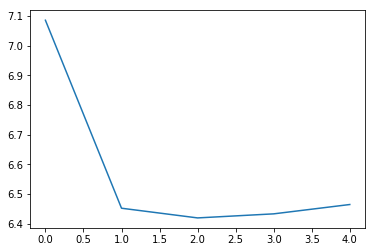

In [18]:
history = model.fit(dataset, epochs=5, steps_per_epoch = 64, callbacks = [checkpoint_callback])
plt.plot(history.history['loss'])

In [0]:
model = build_model(len(words), 256, 1024, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))



In [0]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of words to generate
  num_generate = 100

  # Converting our start string to numbers (vectorizing)
  input_eval = [word_indices[start_string]]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
     
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(indices_word[predicted_id])

  return (start_string + ' '.join(text_generated))


In [24]:
print(generate_text(model, start_string="the"))

thecertified melancholy knight simplicity utmost one breaks at soonest no forerun cannibals would lend sword persuade that conduct of have which delicious wears the like a therefore in order of at all lend drop but my of in so sin thou i for bring a give and cave queen an he so have mind with down once me were a will for keep lewd it and it then our think told which make will we this more may far with down a me better soever blessed thy that my a lady all be upon the the gently a to the
